# for authors

In [1]:
import cPickle as pickle
author_full_name_dict = pickle.load(open("authors_full_name_dict.p", "rb"))

In [2]:
import sqlite3
conng = sqlite3.connect('pmcv1-graph.db') 
cg = conng.cursor()

In [3]:
import Queue
import networkx as nx
def buildfnauthortree(rootnode, mastergraphcursor, fndict, depth = 2):
    _g =nx.DiGraph()
    q = Queue.Queue()
    q.put((rootnode, 0))
    while not q.empty():
        node = q.get()
        if node[1] < depth:
            mastergraphcursor.execute('''SELECT coauthors FROM coauthors WHERE author = ?''', [node[0]])
            coauthors = cg.fetchone()[0].split(',')
            for author in coauthors:
                if unicode(fndict[author][0]+" "+fndict[author][1]) not in _g.nodes():
                    _g.add_edge(unicode(fndict[node[0]][0]+ " "+fndict[node[0]][1]), 
                                unicode(fndict[author][0]+" "+fndict[author][1]))
                    q.put((author, node[1]+1))
    return _g

In [19]:
rootauthor = u'padubidriv.shivaprasad'
g = buildfnauthortree(rootauthor, cg, author_full_name_dict, 2)

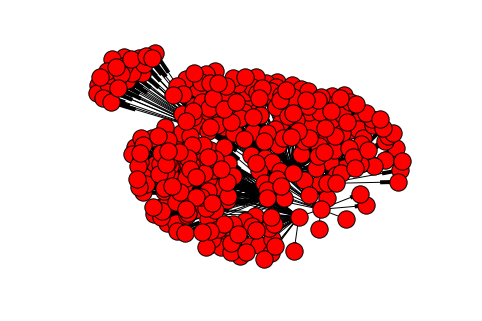

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(g)

In [23]:
#dump graph in json format for d3 to plot
from networkx.readwrite import json_graph
import io, json
with io.open('testgraphdata.json', 'w', encoding='utf-8') as f:
    f.write(unicode(json.dumps(json_graph.tree_data(g, u"Padubidri V. Shivaprasad", 
                                                    attrs={'children': 'children', 'id': 'name'}))))
f.close()

# for citations

In [3]:
import sqlite3
conng = sqlite3.connect('pmcv1-graph.db') 
cg = conng.cursor()

In [16]:
import Queue
import networkx as nx
def buildcitenetwork(rootnode, mastergraphcursor, indepth = 0, outdepth = 2):
    _g =nx.DiGraph()
    q = Queue.Queue()
    #first go in out direction
    q.put((rootnode, 0))
    while not q.empty():
        node = q.get()
        if node[1] < outdepth:
            mastergraphcursor.execute('''SELECT outcites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        _g.add_edge(node[0], cite)
                        q.put((cite, node[1]+1))
            except ValueError: #when there are none
                pass
    #now go in in direction
    q.put((rootnode, 0))
    while not q.empty():
        node = q.get()
        if node[1] < indepth:
            mastergraphcursor.execute('''SELECT incites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        _g.add_edge(cite, node[0])
                        q.put((cite, node[1]+1))
            except ValueError:
                pass
    return _g

In [32]:
g= buildcitenetwork(21437221, cg, 2, 2)

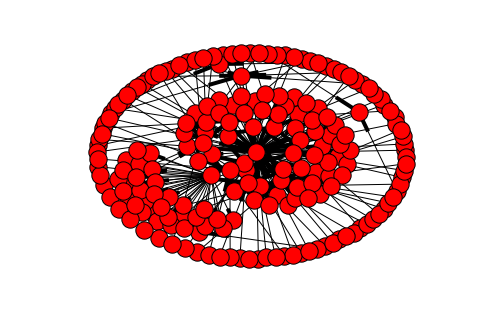

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(g)

In [34]:
#dump graph in json format for d3 to plot
from networkx.readwrite import json_graph
import io, json
with io.open('citetestdata.json', 'w', encoding='utf-8') as f:
    f.write(unicode(json.dumps(json_graph.node_link_data(g, attrs={'source': 'source', 
                                                                   'target': 'target', 
                                                                   'key': 'key', 
                                                                   'id': 'name'}))))
f.close()

# with citation levels colors as attribute
0 = root node;
1 = out cite 1;
2 = out cite 2;
-1 = in cite 1, etc.

In [87]:
import sqlite3
conng = sqlite3.connect('pmcv1-graph.db') 
cg = conng.cursor()

In [88]:
import Queue
import networkx as nx
import colorbrewer
def buildcitenetwork(rootnode, mastergraphcursor, indepth = 0, outdepth = 2, colorscheme = colorbrewer.PuOr):
    _g =nx.DiGraph()
    q = Queue.Queue()
    #set up colors
    _colors = colorscheme[max(outdepth,indepth)*2+1]
    #first go in out direction
    q.put((rootnode, 0))
    _g.add_node(rootnode, color = rgbtohex(_colors[(len(_colors)-1)/2]))
    while not q.empty():
        node = q.get()
        if node[1] < outdepth:
            mastergraphcursor.execute('''SELECT outcites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        _g.add_node(cite, color = rgbtohex(_colors[(len(_colors)-1)/2+node[1]+1]))
                        _g.add_edge(node[0], cite)
                        q.put((cite, node[1]+1))
            except ValueError: #when there are none
                pass
    #now go in in direction
    q.put((rootnode, 0))
    while not q.empty():
        node = q.get()
        if node[1] < indepth:
            mastergraphcursor.execute('''SELECT incites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        _g.add_node(cite, color = rgbtohex(_colors[(len(_colors)-1)/2-node[1]-1]))
                        _g.add_edge(cite, node[0])
                        q.put((cite, node[1]+1))
            except ValueError:
                pass
    return _g

import struct
def rgbtohex(rgbtupleorlistoftuples):
    if type(rgbtupleorlistoftuples) == list:
        returnlist = []
        for tup in rgbtupleorlistoftuples:
            returnlist.append(struct.pack('BBB',*tup).encode('hex'))
        return returnlist
    else:
        return struct.pack('BBB',*rgbtupleorlistoftuples).encode('hex')

In [89]:
g= buildcitenetwork(21437221, cg, 2, 2)

In [90]:
#g.nodes(data=True)

In [95]:
#dump graph in json format for d3 to plot
from networkx.readwrite import json_graph
import io, json
with io.open('citetestdata.json', 'w', encoding='utf-8') as f:
    f.write(unicode(json.dumps(json_graph.node_link_data(g, attrs={'source': 'source',  
                                                                   'target': 'target', 
                                                                   'key': 'key', 
                                                                   'id': 'name',
                                                                   'color': 'color'
                                                                  }))))
f.close()

# with colored citation levels AND first auth ln et al. as label

1. some authors missing due to parser errors, others missing because papers not in PMC
2. would like to do author, date as format but didn't parse the dates. If I re-run I should do this
3. if I get TF-IDF keywords working well could use that

In [1]:
import sqlite3
conng = sqlite3.connect('pmcv1-graph.db') 
cg = conng.cursor()
connfull = sqlite3.connect('pmcv1-full.db') 
cf = connfull.cursor()

In [2]:
import Queue
import networkx as nx
import colorbrewer
def buildcitenetwork(rootnode, mastergraphcursor, authcursor, indepth = 0, outdepth = 2, 
                     colorscheme = colorbrewer.PuOr):
    _g =nx.DiGraph()
    q = Queue.Queue()
    #set up colors
    _colors = colorscheme[max(outdepth,indepth)*2+1]
    #first go in out direction
    q.put((rootnode, 0))
    authcursor.execute('''SELECT ln FROM authors WHERE pmid = ? AND authnum = 0''', [rootnode])
    _g.add_node(rootnode, color = rgbtohex(_colors[(len(_colors)-1)/2]), ln = authcursor.fetchone()[0])
    while not q.empty():
        node = q.get()
        if node[1] < outdepth:
            #authcursor.execute('''SELECT ln FROM authors WHERE pmid = ? AND authnum = 0''', [21437221])
            mastergraphcursor.execute('''SELECT outcites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        authcursor.execute('''SELECT ln FROM authors WHERE pmid = ? AND authnum = 0''', [cite])
                        try: 
                            lastname = authcursor.fetchone()[0]
                        except TypeError:
                            lastname = cite
                        _g.add_node(cite, color = rgbtohex(_colors[(len(_colors)-1)/2+node[1]+1]), ln = lastname)
                        _g.add_edge(node[0], cite)
                        q.put((cite, node[1]+1))
            except ValueError: #when there are none
                pass
    #now go in in direction
    q.put((rootnode, 0))
    while not q.empty():
        node = q.get()
        if node[1] < indepth:
            mastergraphcursor.execute('''SELECT incites FROM cites WHERE pmid = ?''', [node[0]])
            try:
                cites = map(int, cg.fetchone()[0].split(','))
                for cite in cites:
                    if cite not in _g.nodes():
                        authcursor.execute('''SELECT ln FROM authors WHERE pmid = ? AND authnum = 0''', [cite])
                        try: 
                            lastname = authcursor.fetchone()[0]
                        except TypeError:
                            lastname = cite
                        _g.add_node(cite, color = rgbtohex(_colors[(len(_colors)-1)/2-node[1]-1]), ln = lastname)
                        _g.add_edge(cite, node[0])
                        q.put((cite, node[1]+1))
            except ValueError:
                pass
    return _g

import struct
def rgbtohex(rgbtupleorlistoftuples):
    if type(rgbtupleorlistoftuples) == list:
        returnlist = []
        for tup in rgbtupleorlistoftuples:
            returnlist.append(struct.pack('BBB',*tup).encode('hex'))
        return returnlist
    else:
        return struct.pack('BBB',*rgbtupleorlistoftuples).encode('hex')

In [5]:
g = buildcitenetwork(18593145, cg, cf, 2, 2)

In [7]:
from networkx.readwrite import json_graph
import io, json
with io.open('citetestdata.json', 'w', encoding='utf-8') as f:
    f.write(unicode(json.dumps(json_graph.node_link_data(g, attrs={'source': 'source',  
                                                                   'target': 'target', 
                                                                   'key': 'key', 
                                                                   'id': 'name',
                                                                   'color': 'color',
                                                                   'ln': 'ln'
                                                                  }))))
f.close()